In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchode as to
from hydra import compose, initialize
from omegaconf import OmegaConf

from bioplnn.utils import AttrDict, initialize_model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision("high")
torch.cuda.empty_cache()

In [3]:
!nvidia-smi

Mon Mar 10 16:17:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:03:00.0 Off |                    0 |
| N/A   42C    P0             54W /  300W |       3MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
with initialize(version_base=None, config_path="config/", job_name="testing"):
    config = compose(
        config_name="config",
        overrides=["data=cifar10v1", "model=topo_sunny"],
    )
config = OmegaConf.to_container(config, resolve=True)
config = AttrDict(config)
sunny_root = "/om/user/sunnyd/dros-vision/"

In [5]:
# Load data
neuron_ids = pd.read_csv(sunny_root + "visual_neuron_ids.csv")
input_neuron_ids = pd.read_csv(sunny_root + "visual_column_assignment.csv")
column_data = torch.tensor(
    np.load(sunny_root + "moving_mnist_vision.npy"), dtype=torch.float32
)
lookup = dict(zip(neuron_ids["root_id"].to_list(), neuron_ids.index))
input_indices = torch.tensor(input_neuron_ids["root_id"].map(lookup))
column_ids = torch.tensor(input_neuron_ids["column_ids"] - 1)

In [6]:
num_neurons = len(neuron_ids)
num_input_neurons = len(input_neuron_ids)

In [7]:
def save_connectivity():
    connectivity_hh = np.load(sunny_root + "visual_adj_matrix_20240711.npy")
    connectivity_hh = torch.tensor(connectivity_hh).to_sparse_coo().coalesce()

    # Load connectivity_ih
    indices_ih = torch.stack(
        (
            input_indices,
            torch.arange(input_neuron_ids.shape[0]),
        )
    )

    values_ih = torch.ones(indices_ih.shape[1])

    connectivity_ih = torch.sparse_coo_tensor(
        indices_ih,
        values_ih,
        (num_neurons, num_input_neurons),
        check_invariants=True,
    ).coalesce()

    # Save connectivity
    torch.save(connectivity_hh, config.model.rnn_kwargs.connectivity_hh)  # type: ignore
    torch.save(connectivity_ih, config.model.rnn_kwargs.connectivity_ih)

    # Save input indices
    torch.save(input_indices, config.model.rnn_kwargs.input_indices)


# save_connectivity()

In [8]:
model = initialize_model(**config.model)

/rdma/vast-rdma/user/valmiki/bioplnn/src/bioplnn/models/connectome.py:149: UserWarning: Both random initialization and connectivity initialization are provided. Using connectivity initialization.
  warn(


In [9]:
print(
    f"HH sparsity {model.rnn.hh.values.shape[0] / (model.rnn.hh.in_features * model.rnn.hh.out_features):.2%}"
)

HH sparsity 0.20%


In [10]:
# connectivity_hh = torch.load(
#     config.model.rnn_kwargs.connectivity_hh, weights_only=True
# )
# connectivity_ih = torch.load(
#     config.model.rnn_kwargs.connectivity_ih, weights_only=True
# )
# input_indices = torch.load(
#     config.model.rnn_kwargs.input_indices, weights_only=True
# )

# pool = torch.nn.AdaptiveMaxPool2d((100, 100))
# connectivity = pool(connectivity_hh.unsqueeze(0).to_dense().float())
# plt.imshow(
#     connectivity.squeeze(0).detach().cpu().numpy(),
#     cmap="gray",
# )

In [11]:
def f(t: torch.Tensor, y: torch.Tensor, args: dict):
    h = y.t()

    x = args["x"]
    bias = args["bias"]
    leak = args["leak"]
    T = args["tau"]

    x_t = x[:, int(t * 10), column_ids].t()

    h = 1 / T * (-h * leak + bias + model.rnn.hh(h) + 10 * model.rnn.ih(x_t))

    return h.t()


In [29]:
x = column_data[:1].to(device)
y0 = torch.randn(len(neuron_ids)).unsqueeze(0).to(device)
t_eval = torch.linspace(0.0, 1.0, 10).unsqueeze(0).to(device)

term = to.ODETerm(f, with_args=True)  # type: ignore
step_method = to.Dopri5(term=term)
step_size_controller = to.IntegralController(atol=1e-6, rtol=1e-3, term=term)
# solver = to.AutoDiffAdjoint(
#     step_method, step_size_controller, backprop_through_step_size_control=False
# ).to(device)
solver = to.BacksolveAdjoint(term, step_method, step_size_controller).to(
    device
)
# solver = torch.compile(solver)

In [30]:
x.dtype

torch.float32

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
y0.dtype

torch.float32

In [33]:
# Solve ODE
torch.cuda.empty_cache()
problem = to.InitialValueProblem(y0=y0, t_eval=t_eval)
sol = solver.solve(
    problem,
    args={
        "x": x,
        "bias": 0.1,
        "leak": 20.0,
        "tau": 10.0,
    },
)
ys = sol.ys.transpose(0, 1)

In [34]:
preds = model.out_layer(ys[0])
labels = torch.rand((1, 10)).to(device)
print(f"preds: {preds}")
print(f"labels: {labels}")
print(f"preds shape: {preds.shape}")
print(f"labels shape: {labels.shape}")

preds: tensor([[-0.0699,  0.3276,  0.0266, -0.5618,  0.2015, -0.3049,  0.2818, -0.3217,
          0.0569,  0.1768]], device='cuda:0', grad_fn=<AddmmBackward0>)
labels: tensor([[0.7775, 0.3807, 0.2145, 0.4794, 0.3921, 0.4407, 0.5605, 0.6015, 0.2553,
         0.6862]], device='cuda:0')
preds shape: torch.Size([1, 10])
labels shape: torch.Size([1, 10])


In [36]:
loss = torch.nn.CrossEntropyLoss()(preds, labels)
optimizer.zero_grad()
loss.backward()
optimizer.step()
print(f"loss: {loss}")

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [14]:
print("ys info:")
print(ys.shape)

ys info:
torch.Size([1, 20, 47521])


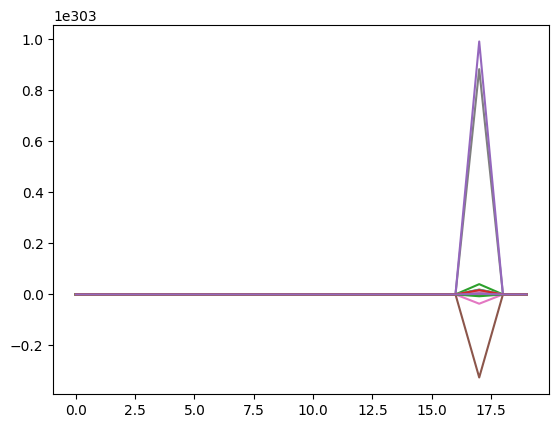

In [ ]:
plt.plot(
    ys.squeeze()[:, torch.randint(0, 47521, (25,))].detach().cpu().numpy()
)
plt.show()